In [9]:
%load_ext autoreload
%autoreload 2

import os
import json
from functools import reduce
import numpy as np

from conf import conf
from models.tensorflow.conf import tf_conf

import tensorflow as tf
tfk = tf.keras
import tensorflow_probability as tfp
tfd = tfp.distributions
import tensorflow_datasets as tfds

import plotly.graph_objs as go
import plotly.express as px

from models.tensorflow.rnade import Rnade
from models.tensorflow.rnade_deep import RnadeDeep
from models.tensorflow.maf import MAF
from models.tensorflow.mdn import MDN
from models.tensorflow.monde import MONDE
from models.tensorflow.monde_ar import MondeAR
from data import registry
from models.tensorflow.compute import get_device
from utils import elapsed_timer

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
n_data=10000
batch_size=512
max_epochs=100000
os.environ['CUDA_VISIBLE_DEVICES']="0"
tf_conf.per_process_gpu_memory = {'0':1024,'1':1024}
conf.visible_device_list = [0]
device = get_device(tf_conf, conf)

In [3]:
conf.dir = '{ROOT}/density/sin_normal'
data_loader = registry.sin_np(x_slice=slice(None, 1), y_slice=slice(1, None), size=10000, start=-2, stop=2, scale=0.2)

loaded data: NpSinusoid-data.memmap


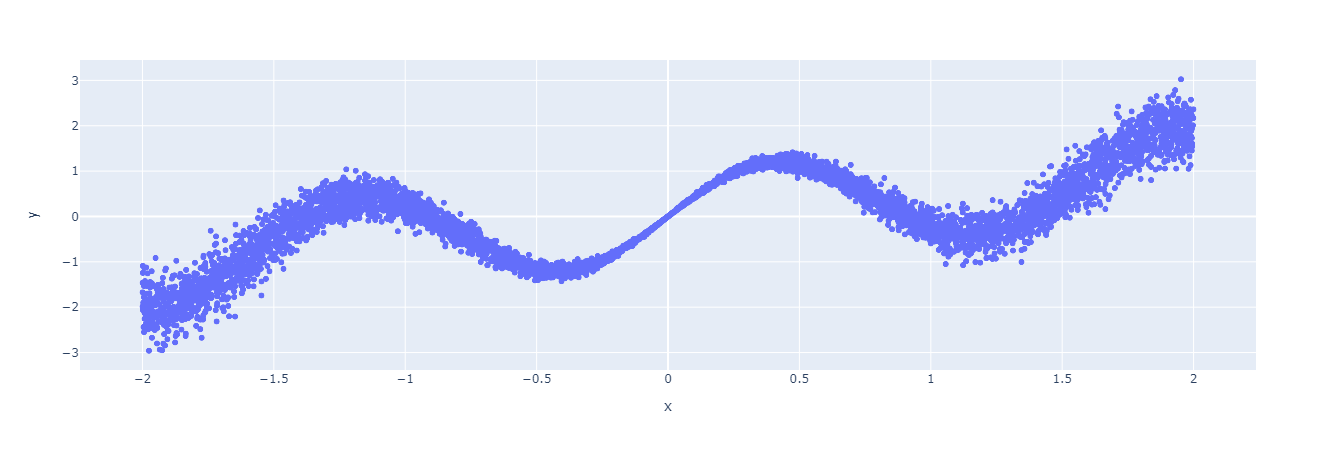

In [4]:
px.scatter(x=data_loader.train_data[:,0],y=data_loader.train_data[:,1])

In [5]:
train_dataset = tf.data.Dataset.from_tensor_slices(
        ((data_loader.train_y, data_loader.train_x), np.zeros((len(data_loader.train_y), 0), dtype=np.float32)))
train_dataset = train_dataset.repeat(None)
train_dataset = train_dataset.shuffle(buffer_size=len(data_loader.train_y))
train_dataset = train_dataset.prefetch(3 * batch_size)
train_dataset = train_dataset.batch(batch_size)

In [10]:
with tf.device(device):
#     model = Rnade(k_mix = 10, hidden_units=128, component_distribution="normal") #4,127
#     model = Rnade(k_mix = 10, hidden_units=128, component_distribution="laplace") #4,127
#     model = RnadeDeep(k_mix = 10, arch=[64,64], component_distribution="normal") # 6,366
#     model = RnadeDeep(k_mix = 10, arch=[64,64], component_distribution="laplace") # 6,366
#     model = MAF(num_bijectors=2, hidden_units=[32,32], covariate_hidden_units=[16,16], batch_norm=False) #5,188
#     model = MDN(arch=[64,64], num_mixtures=10) # 6,238
#     model = MONDE(cov_type="const_cov", arch_hxy=[64,64], arch_x_transform=[64,64], arch_cov_transform=None, hxy_x_size=32, covariance_learning_rate=None)
    model = MondeAR(number_of_layers=3, number_of_blocks=10,shuffle_order = False, number_of_evaluations=1,order=None, use_companion_biases = False, non_linear_transform = 'tanh')
    model.build([[None,1],[None,1]])

ValueError: You cannot build your model by calling `build` if your layers do not support float type inputs. Instead, in order to instantiate and build your model, `call` your model on real tensor data (of the correct dtype).

In [ ]:
model.summary()

In [27]:
def loss_fn(_, log_prob):
    return -tf.reduce_mean(log_prob)

model.compile(optimizer=tfk.optimizers.Adam(), loss=loss_fn)

In [28]:
callbacks = []
callbacks.append(tfk.callbacks.TerminateOnNaN())
callbacks.append(tfk.callbacks.History())
callbacks.append(tfk.callbacks.EarlyStopping(monitor='loss', patience=30))

steps_per_epoch = int(np.ceil(len(data_loader.train_y) / batch_size))
with elapsed_timer("training"):
    history = model.fit(x=train_dataset, verbose=0, epochs=max_epochs, steps_per_epoch=steps_per_epoch, callbacks=callbacks)

training took 59.563923184992746 seconds


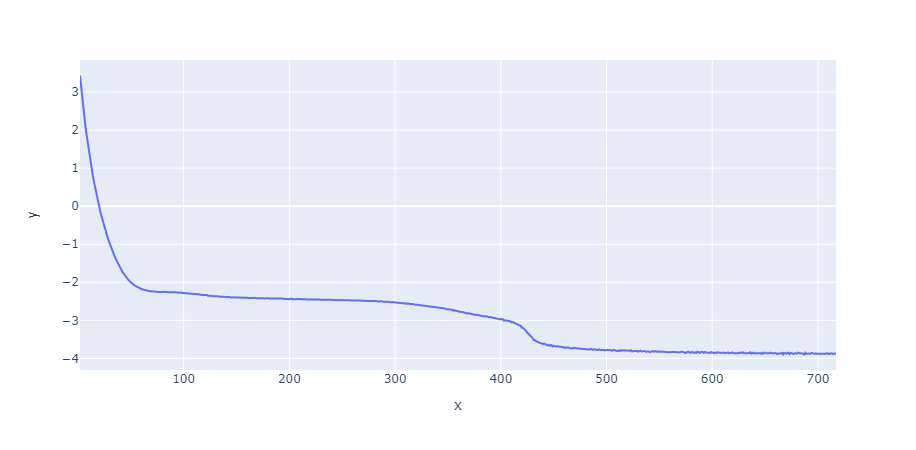

In [29]:
px.line(x=history.epoch[2:],y=history.history['loss'][2:])

In [30]:
y_maxes = np.array([2,2],np.float32)
y_mins = np.array([-2,-2],np.float32)
y1_grid=np.linspace(y_mins[0],y_maxes[0],100, dtype=np.float32)
y2_grid=np.linspace(y_mins[1],y_maxes[1],100, dtype=np.float32)
yy1,yy2 = np.meshgrid(y1_grid,y2_grid)

In [31]:
prob = model.prob(tf.convert_to_tensor(yy2.reshape([-1,1])),tf.convert_to_tensor(yy1.reshape([-1,1])), training=1).numpy()

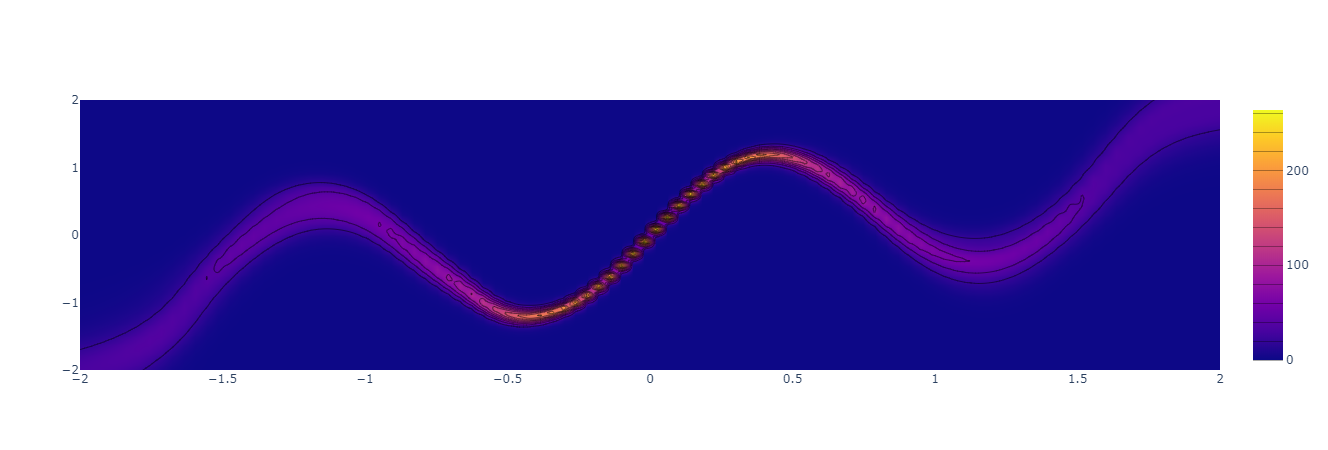

In [32]:
fig = go.Figure(data =
    go.Contour(
        z=prob.reshape(y1_grid.size,y2_grid.size),
        x=y1_grid,
        y=y2_grid,        
        contours_coloring='heatmap'
    ))
fig.show()